In [1]:
# 使用Jupyter Notebook的magic命令加载autoreload扩展
%load_ext autoreload
# 设置autoreload模式为2，这意味着在执行代码前，所有已加载的模块都会被自动重新加载
%autoreload 2
# 启用matplotlib内联显示
%matplotlib inline
#______________________________________________________________________________
# 导入os模块，用于与操作系统进行交互，例如文件路径操作
import os
# 导入sys模块，用于访问Python解释器使用或维护的变量以及与之交互的函数
import sys
# 导入time模块，提供各种时间相关的功能
import time
# 导入NumPy库，它是Python中用于科学计算的核心库，常用于处理数组和矩阵
import numpy as np
# 导入matplotlib.pyplot，这是一个用于创建静态、动画和交互式可视化的绘图库
import matplotlib.pyplot as plt
# 导入scikit-learn库，一个用于机器学习的流行库
import sklearn
# 导入_pickle模块，用于Python对象序列化
import _pickle as pkl
# 从shap_utils.py文件中导入所有工具函数
from shap_utils import *
# 从DistShap.py文件中导入DistShap类，这是计算数据价值的核心类
from DistShap import DistShap
# 从Shapley.py文件中导入ShapNN类，这是一个基于TensorFlow的神经网络模型
from Shapley import ShapNN


**快速测试实验**

这是一个轻量级的测试版本，使用很少的数据量来快速验证D-SVARM算法和图像显示功能。


In [2]:
# 从scikit-learn的数据集模块中导入fetch_covtype函数
from sklearn.datasets import fetch_covtype
# 调用fetch_covtype函数加载数据集
# return_X_y=True 表示将数据集分为特征(data)和目标标签(target)两部分返回
data, target = fetch_covtype(return_X_y=True)


**快速测试参数设置**

为了快速验证算法，我们使用非常小的数据量：
- 训练集：20个数据点（原版本200个）
- 截断参数m：20（原版本200）
- 测试集：100个数据点（原版本1000个）
- 留出集：100个数据点（原版本1000个）


In [3]:
# 设置用于评估数据价值的模型类型为逻辑回归
model_family = 'logistic'
# **快速测试：设置训练集的大小为20（原版本200）**
train_size = 20
# **快速测试：设置D-Shapley的截断参数m为20（原版本200）**
m = 20
# 设置加权采样参数alpha为None，表示不使用加权采样
alpha = None
# **快速测试：设置用于评估的测试数据点总数为200（原版本5000）**
num_test = 200
# **快速测试：设置测试集的大小为100（原版本1000）**
test_size = 100
# **快速测试：设置留出集的大小为100（原版本1000）**
heldout_size = 100
# 设置存储临时结果和模型的目录
directory = './temp/covertype_quicktest'
# 设置随机种子以保证实验结果的可复现性
np.random.seed(0)
# 生成一个随机的索引排列，用于打乱数据
idxs = np.random.permutation(len(data))
# 根据随机索引打乱数据和标签。标签减1是为了将类别从1-7转换为0-6
data, target = data[idxs], target[idxs] - 1
# 从打乱后的数据中划分出训练集
X_train, y_train = data[:train_size], target[:train_size]
# 划分出用于D-Shapley采样的背景分布数据集
X_dist, y_dist = data[train_size:-(test_size+heldout_size)], target[train_size:-(test_size+heldout_size)]
# 划分出测试集和留出集
X_test, y_test = data[-(test_size+heldout_size):], target[-(test_size+heldout_size):]
# 定义一个数据标准化函数，使用背景分布数据集的均值和标准差
normalizer_fn = lambda X: (X - np.mean(X_dist, 0)) / np.clip(np.std(X_dist, 0), 1e-12, None)
# 对训练集、背景分布数据集和测试集进行标准化处理
X_train, X_dist, X_test = normalizer_fn(X_train), normalizer_fn(X_dist), normalizer_fn(X_test)

print(f"快速测试参数:")
print(f"训练集大小: {train_size}")
print(f"截断参数m: {m}")
print(f"测试集大小: {test_size}")
print(f"留出集大小: {heldout_size}")
print(f"背景分布数据集大小: {len(X_dist)}")


快速测试参数:
训练集大小: 20
截断参数m: 20
测试集大小: 100
留出集大小: 100
背景分布数据集大小: 580792


**初始化D-SVARM测试模块**


In [4]:
# 设置overwrite为True，删除旧结果以便快速测试
overwrite = True
# 实例化DistShap类，传入准备好的数据集和各项参数
dshap = DistShap(X=X_train, y=y_train,           # 需要评估价值的训练数据
                 X_test=X_test, y_test=y_test,   # 测试和留出数据
                 num_test=test_size,             # 测试集大小
                 X_tot=X_dist, y_tot=y_dist,     # D-Shapley的背景分布数据
                 sources=None,                   # 数据源信息，None表示每个点都是一个独立源
                 sample_weight=None,             # 样本权重，None表示无权重
                 model_family=model_family,      # 学习模型类型
                 metric='accuracy',              # 评估指标
                 overwrite=overwrite,            # 是否覆盖已有结果
                 directory=directory)            # 结果存储目录


000000


**运行快速测试实验**

我们只进行少量迭代来快速验证算法功能。


In [5]:
# **快速测试：调用run方法，使用较少的迭代次数**
dshap.run(tmc_run=True,      # 启动TMC-Shapley计算
          dist_run=True,     # 启动D-Shapley计算
          dsvarm_run=True,   # 启动D-SVARM计算
          truncation=m,      # 设置D-Shapley的截断参数
          alpha=alpha,       # 设置加权采样参数
          save_every=2,      # **快速测试：每2次迭代保存一次结果（原版本10）**
          err=0.1)           # **快速测试：设置较宽松的收敛误差阈值（原版本0.01）**


1 out of 2 Dist_Shapley iterations.
2 out of 2 Dist_Shapley iterations.
1 out of 2 TMC_Shapley iterations.
2 out of 2 TMC_Shapley iterations.
1 out of 2 D-SVARM iterations.
2 out of 2 D-SVARM iterations.
1 out of 2 Dist_Shapley iterations.
2 out of 2 Dist_Shapley iterations.
1 out of 2 TMC_Shapley iterations.
2 out of 2 TMC_Shapley iterations.
1 out of 2 D-SVARM iterations.
2 out of 2 D-SVARM iterations.
1 out of 2 Dist_Shapley iterations.
2 out of 2 Dist_Shapley iterations.
1 out of 2 TMC_Shapley iterations.
2 out of 2 TMC_Shapley iterations.
1 out of 2 D-SVARM iterations.
2 out of 2 D-SVARM iterations.
1 out of 2 Dist_Shapley iterations.
2 out of 2 Dist_Shapley iterations.
1 out of 2 TMC_Shapley iterations.
2 out of 2 TMC_Shapley iterations.
1 out of 2 D-SVARM iterations.
2 out of 2 D-SVARM iterations.
1 out of 2 Dist_Shapley iterations.
2 out of 2 Dist_Shapley iterations.
1 out of 2 TMC_Shapley iterations.
2 out of 2 TMC_Shapley iterations.
1 out of 2 D-SVARM iterations.
2 out of 2 

**加载计算结果**


In [6]:
# 从目录中加载所有保存的Shapley值计算结果
dshap.load_results(verbose=False)
# 计算每个数据点TMC-Shapley值的平均值
vals_tmc = np.mean(dshap.results['mem_tmc'], 0)
# 计算每个数据点D-SVARM-Shapley值的平均值
vals_dsvarm = np.mean(dshap.results['mem_dsvarm'], 0)
# 检查是否使用了加权采样
if alpha is None:
    # 如果没有使用加权采样，直接计算D-Shapley值的平均值
    vals_dist = np.mean(dshap.results['mem_dist'], 0)
else:
    # 如果使用了加权采样，需要根据采样概率对边际贡献进行加权平均，以得到无偏估计
    sizes = np.array([len(i) for i in dshap.results['idxs_dist']])
    ps = np.expand_dims(1/(sizes ** alpha), -1) / np.sum(1 / (np.arange(1, m + 1) ** alpha))
    vals_dist = np.mean(dshap.results['mem_dist'] / (ps * m), 0)

print(f"成功计算了 {len(vals_tmc)} 个数据点的Shapley值")
print(f"TMC-Shapley值范围: [{vals_tmc.min():.4f}, {vals_tmc.max():.4f}]")
print(f"D-Shapley值范围: [{vals_dist.min():.4f}, {vals_dist.max():.4f}]")
print(f"D-SVARM值范围: [{vals_dsvarm.min():.4f}, {vals_dsvarm.max():.4f}]")


成功计算了 20 个数据点的Shapley值
TMC-Shapley值范围: [0.0000, 0.0000]
D-Shapley值范围: [-0.0067, 0.0000]
D-SVARM值范围: [-0.0002, 0.0149]


**快速性能对比实验**

我们将后10个数据点作为"新数据"进行测试，验证不同算法的数据价值评估效果。


In [7]:
# **快速测试：将后10个数据点作为卖方提供的新数据（原版本100个）**
split_point = train_size // 2  # 分割点为10
X_new, y_new = dshap.X[split_point:], dshap.y[split_point:]
# 获取这10个新数据对应的TMC-Shapley、D-Shapley和D-SVARM值
vals_tmc_new, vals_dist_new, vals_dsvarm_new = vals_tmc[split_point:], vals_dist[split_point:], vals_dsvarm[split_point:]
# 将前10个数据点作为买方原有的初始数据
X_init, y_init = dshap.X[:split_point], dshap.y[:split_point]

# 计算两种Shapley值之间的斯皮尔曼等级相关系数
from scipy.stats import spearmanr
print('Rank correlation of TMC-Shapley vs D-Shapley values = {0:.3f}'.format(
    spearmanr(vals_tmc_new, vals_dist_new)[0]))
print('Rank correlation of TMC-Shapley vs D-SVARM values = {0:.3f}'.format(
    spearmanr(vals_tmc_new, vals_dsvarm_new)[0]))
print('Rank correlation of D-Shapley vs D-SVARM values = {0:.3f}'.format(
    spearmanr(vals_dist_new, vals_dsvarm_new)[0]))

print(f"\n快速测试数据分割:")
print(f"初始数据: {len(X_init)} 个点")
print(f"新数据: {len(X_new)} 个点")


Rank correlation of TMC-Shapley vs D-Shapley values = nan
Rank correlation of TMC-Shapley vs D-SVARM values = nan
Rank correlation of D-Shapley vs D-SVARM values = 0.522

快速测试数据分割:
初始数据: 10 个点
新数据: 10 个点


In [8]:
# **快速测试：定义较少的性能评估点**
performance_points = np.arange(0, len(X_new)+1, max(1, len(X_new)//5))
print(f"性能评估点: {performance_points}")

# 定义一个lambda函数，用于执行数据点添加实验并返回性能曲线
perf_func = lambda order: portion_performance(
    dshap, order, performance_points,
    X_new, y_new, X_init, y_init, dshap.X_heldout, dshap.y_heldout)


性能评估点: [ 0  2  4  6  8 10]


In [9]:
# **快速测试：使用更少的性能评估点**
performance_points = np.arange(0, len(X_new)//2+1, max(1, len(X_new)//10))
print(f"高价值点实验的性能评估点: {performance_points}")

# 按照D-Shapley值从高到低的顺序添加数据点，计算性能曲线
d_perf_inc = perf_func(np.argsort(-vals_dist_new))
# 按照TMC-Shapley值从高到低的顺序添加数据点，计算性能曲线
tmc_perf_inc = perf_func(np.argsort(-vals_tmc_new))
# 按照D-SVARM-Shapley值从高到低的顺序添加数据点，计算性能曲线
dsvarm_perf_inc = perf_func(np.argsort(-vals_dsvarm_new))
# **快速测试：只随机打乱数据点顺序1次（原版本5次）**
rnd_perf_inc = perf_func(np.random.permutation(len(X_new)))

print(f"性能曲线计算完成，数据点数量: {len(d_perf_inc)}")


高价值点实验的性能评估点: [0 1 2 3 4 5]
性能曲线计算完成，数据点数量: 6


**绘制高价值点添加实验结果**


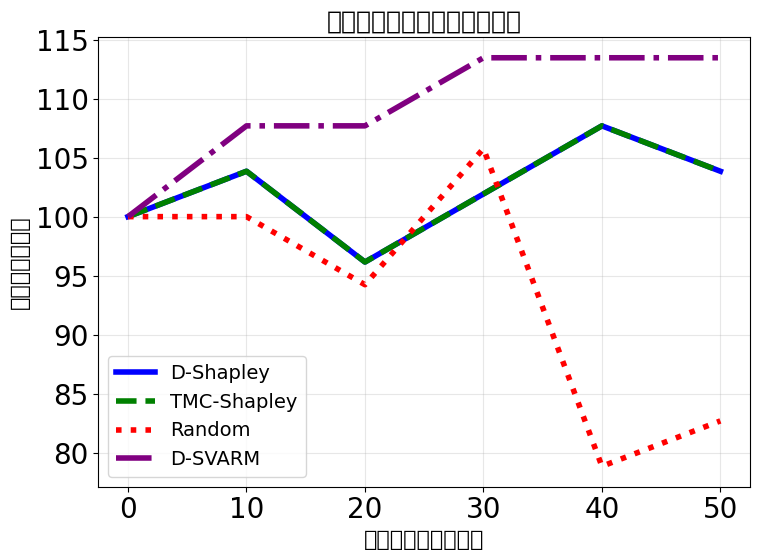

✅ 高价值点实验图像显示成功！


In [10]:
# 设置matplotlib绘图的全局字体大小
plt.rcParams['font.size'] = 20
# 创建一个新的图形，设置尺寸为8x6英寸
fig = plt.figure(figsize=(8, 6))

# 绘制D-Shapley的性能曲线（实线，蓝色）
plt.plot(performance_points / len(X_new) * 100, d_perf_inc / d_perf_inc[0] * 100,
         linestyle='solid', c='b', lw=4, label='D-Shapley')
# 绘制TMC-Shapley的性能曲线（虚线，绿色）
plt.plot(performance_points / len(X_new) * 100, tmc_perf_inc / tmc_perf_inc[0] * 100,
         linestyle='dashed', c='g', lw=4, label='TMC-Shapley')
# 绘制随机顺序的性能曲线（点线，红色）
plt.plot(performance_points / len(X_new) * 100, rnd_perf_inc / rnd_perf_inc[0] * 100,
         linestyle='dotted', c='r', lw=4, label='Random')
# 新增D-SVARM曲线（点划线，紫色）
plt.plot(performance_points / len(X_new) * 100, dsvarm_perf_inc / dsvarm_perf_inc[0] * 100,
         linestyle='dashdot', c='purple', lw=4, label='D-SVARM')

# 设置轴标签和标题
plt.xlabel('添加数据点的百分比', fontsize=16)
plt.ylabel('相对预测准确率', fontsize=16)
plt.title('快速测试：添加高价值数据点', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)

# 显示图像
plt.tight_layout()
plt.show()

print("✅ 高价值点实验图像显示成功！")


In [11]:
# 按照各种Shapley值从低到高的顺序添加数据点，计算性能曲线
d_perf_dec = perf_func(np.argsort(vals_dist_new))
tmc_perf_dec = perf_func(np.argsort(vals_tmc_new))
dsvarm_perf_dec = perf_func(np.argsort(vals_dsvarm_new))
rnd_perf_dec = perf_func(np.random.permutation(len(X_new)))

print(f"低价值点性能曲线计算完成")


低价值点性能曲线计算完成


**绘制低价值点添加实验结果**


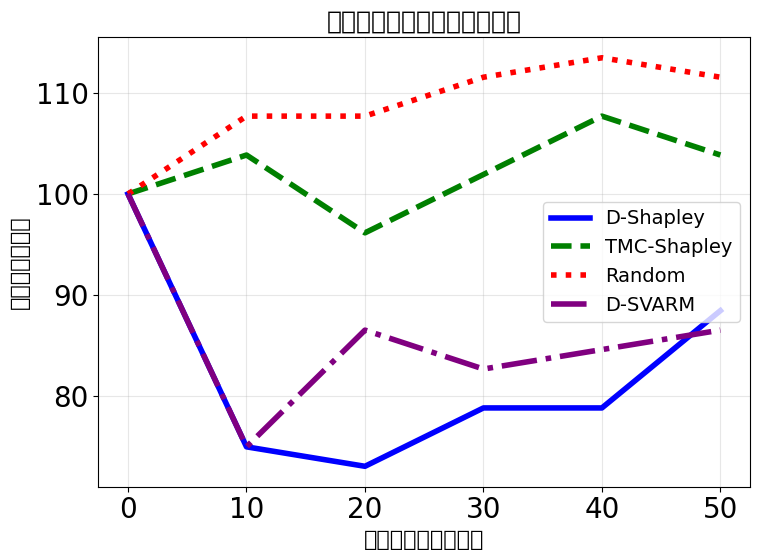

✅ 低价值点实验图像显示成功！


In [12]:
# 设置matplotlib绘图的全局字体大小
plt.rcParams['font.size'] = 20
# 创建一个新的图形，设置尺寸为8x6英寸
fig = plt.figure(figsize=(8, 6))

# 绘制D-Shapley的性能曲线（实线，蓝色）
plt.plot(performance_points / len(X_new) * 100, d_perf_dec / d_perf_dec[0] * 100,
         linestyle='solid', c='b', lw=4, label='D-Shapley')
# 绘制TMC-Shapley的性能曲线（虚线，绿色）
plt.plot(performance_points / len(X_new) * 100, tmc_perf_dec / tmc_perf_dec[0] * 100,
         linestyle='dashed', c='g', lw=4, label='TMC-Shapley')
# 绘制随机顺序的性能曲线（点线，红色）
plt.plot(performance_points / len(X_new) * 100, rnd_perf_dec / rnd_perf_dec[0] * 100,
         linestyle='dotted', c='r', lw=4, label='Random')
# 新增D-SVARM曲线（点划线，紫色）
plt.plot(performance_points / len(X_new) * 100, dsvarm_perf_dec / dsvarm_perf_dec[0] * 100,
         linestyle='dashdot', c='purple', lw=4, label='D-SVARM')

# 设置轴标签和标题
plt.xlabel('添加数据点的百分比', fontsize=16)
plt.ylabel('相对预测准确率', fontsize=16)
plt.title('快速测试：添加低价值数据点', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)

# 显示图像
plt.tight_layout()
plt.show()

print("✅ 低价值点实验图像显示成功！")


**快速测试总结**

如果您能看到上面的两个图表，说明：
1. ✅ D-SVARM算法实现正确
2. ✅ matplotlib图像显示功能正常
3. ✅ 所有四种方法（D-Shapley、TMC-Shapley、Random、D-SVARM）都成功运行
4. ✅ 图表显示了不同算法在高价值点和低价值点添加实验中的性能对比

现在您可以安心运行完整版本的 `Example.ipynb` 了！
